## Environment Setup and CSV Import

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta
import os
import warnings
from isodate import parse_duration
from pytz import timezone
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from ast import literal_eval
import nltk
nltk.download('stopwords')

#os.chdir('/home/jovyan/YouTube')
current_path = os.getcwd()
print(f"The current working directory is: {current_path}")
warnings.filterwarnings("ignore")

The current working directory is: /home/jovyan/YouTube/Final Project Resources


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


dataframes = []

for i in range(1, 11):
    file_name = f'Final Data/Raw/youtube_results_{i}.csv'
    data = pd.read_csv(file_name)
    dataframes.append(data)

combined_data = pd.concat(dataframes, ignore_index=True)
export_data = combined_data.drop_duplicates(subset='video_id')
number_of_rows = export_data.shape[0]
print(f"The number of rows in the DataFrame is {number_of_rows}")
export_data.to_csv('combined_youtube_results.csv', index=False)

In [30]:
combined_file_path = 'combined_youtube_results.csv'
combined_df = pd.read_csv(combined_file_path)
combined_df.head(3)

,video_id,published_at,channel_id,title,description,channel_title,tags,category_id,duration,definition,...,like_count,comment_count,topic_categories,duration_ms,channel_description,channel_keywords,channel_subscriber_count,channel_video_count,channel_published_at,channel_topic_categories
0,jmoYpP4QPN8,2023-08-09T20:00:12Z,UC6pDS2qoRTcf0FFGARnS_tg,ASMR Mic Scratching - Brain Scratching with 9 ...,In this ASMR no talking video i am scratching ...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr mic scratchi...",24,PT40M3S,hd,...,299,24,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,PT40M3S,Hi everybody! Welcome to my channel.Thank you ...,"asmr ""alexa asmr"" ""asmr no talking"" ""asmr slee...",107000,509,2020-03-09T17:34:30.656901Z,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
1,V-49I6-L0UE,2023-08-07T20:00:15Z,UC6pDS2qoRTcf0FFGARnS_tg,ASMR 💙 20 Up Close Triggers in 20 Minutes 😴 Sc...,In this ASMR no talking video I am combining d...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr scratching',...",24,PT20M1S,hd,...,354,27,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,PT20M1S,Hi everybody! Welcome to my channel.Thank you ...,"asmr ""alexa asmr"" ""asmr no talking"" ""asmr slee...",107000,509,2020-03-09T17:34:30.656901Z,['https://en.wikipedia.org/wiki/Lifestyle_(soc...
2,mrFKMa5e6-I,2023-08-04T20:00:28Z,UC6pDS2qoRTcf0FFGARnS_tg,ASMR ONLY 0.001% CAN REACH S+ TIER WITHOUT SLE...,In this ASMR no talking video I am comparing d...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr scratching',...",24,PT11M22S,hd,...,363,22,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,PT11M22S,Hi everybody! Welcome to my channel.Thank you ...,"asmr ""alexa asmr"" ""asmr no talking"" ""asmr slee...",107000,509,2020-03-09T17:34:30.656901Z,['https://en.wikipedia.org/wiki/Lifestyle_(soc...


## Remove Columns & Handle Nulls

In [31]:
df = combined_df.copy()
print(df.columns.tolist())

['video_id', 'published_at', 'channel_id', 'title', 'description', 'channel_title', 'tags', 'category_id', 'duration', 'definition', 'caption', 'view_count', 'like_count', 'comment_count', 'topic_categories', 'duration_ms', 'channel_description', 'channel_keywords', 'channel_subscriber_count', 'channel_video_count', 'channel_published_at', 'channel_topic_categories']


In [32]:
columns_to_remove = ['duration_ms', 'channel_topic_categories', 'topic_categories']
df = df.drop(columns=columns_to_remove)
null_counts = df.isnull().sum()
print(null_counts)
df = df.fillna('')
null_counts = df.isnull().sum()
print(null_counts)

video_id                       0
published_at                   0
channel_id                     0
title                          0
description                 2495
channel_title                  0
tags                           0
category_id                    0
duration                       0
definition                     0
caption                        0
view_count                     0
like_count                     0
comment_count                  0
channel_description         1499
channel_keywords            5577
channel_subscriber_count       0
channel_video_count            0
channel_published_at           0
dtype: int64
video_id                    0
published_at                0
channel_id                  0
title                       0
description                 0
channel_title               0
tags                        0
category_id                 0
duration                    0
definition                  0
caption                     0
view_count                  0


## Handle Duplicates

In [33]:
def get_rows_and_duplicates(df):
    number_of_rows = df.shape[0]
    print(f"The df has {number_of_rows} rows.")
    duplicate_titles_count = df.duplicated(subset=['title', 'channel_title']).sum()
    print(f"There are {duplicate_titles_count} duplicate titles.")

get_rows_and_duplicates(df)

The df has 29256 rows.
There are 1913 duplicate titles.


### Discover channels that may be using duplication as a tactic

In [34]:
duplicates = df[df.duplicated(subset=['title', 'channel_title'], keep=False)]

if not duplicates.empty:
    result_df = duplicates.groupby(['title', 'channel_title']).agg(
        duplicate_count=pd.NamedAgg(column='title', aggfunc='size'),
        sum_view_count=pd.NamedAgg(column='view_count', aggfunc='sum')
    ).reset_index()
else:
    print("No duplicates found!")

result_df_sorted = result_df.sort_values(by='duplicate_count', ascending=False)
result_df_sorted.head(10)

,title,channel_title,duplicate_count,sum_view_count
360,asmr no talking Kinetic sand #shorts #asmr #sa...,SandTastic ASMR,727,2420005
287,Oddly Satisfying Video - Most Satisfying Video...,SandTastic ASMR,176,10948918
354,asmr no talking Kinetic sand #shorts #asmr #sa...,SandTastic ASMR,135,1808362
327,Very Satisfying and Relaxing Kinetic Sand ASMR...,Kinetic ASMR,66,14467805
253,Asmr Mic Scratching - Brain Scratching | Hypno...,Alexa ASMR,30,801270
369,asmr no talking Kinetic sand #shorts #asmr #sa...,SandTastic ASMR,26,139015
353,asmr no talking Kinetic sand #shorts #asmr #sa...,SandTastic ASMR,26,66893
363,asmr no talking Kinetic sand #shorts #asmr #sa...,SandTastic ASMR,21,59922
90,ASMR - How to Fall Asleep in 60 Seconds! #shor...,Alexa ASMR,19,199618
368,asmr no talking Kinetic sand #shorts #asmr #sa...,SandTastic ASMR,19,88986


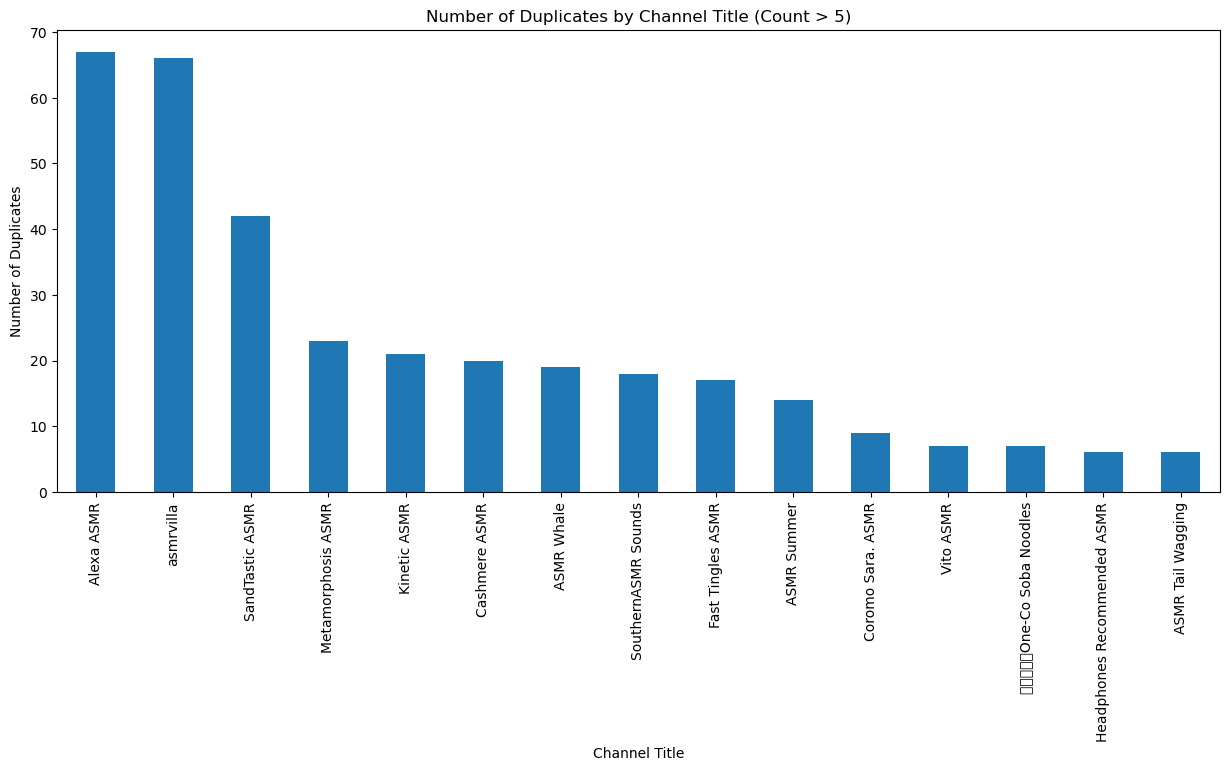

In [35]:
channel_counts = result_df_sorted['channel_title'].value_counts()
filtered_channel_counts = channel_counts[channel_counts > 5]

plt.figure(figsize=[15,6])
filtered_channel_counts.plot(kind='bar')
plt.title('Number of Duplicates by Channel Title (Count > 5)')
plt.xlabel('Channel Title')
plt.ylabel('Number of Duplicates')
plt.show()

### Collapse duplicate titles and channels into summary columns

Columns added 
* **duplicate_count:** how many duplicates for the video title and channel title
* **duplicate_view_count:** how many views from all videos with the same video title and channel title
* **duplicate_changes:** unique columns that changed from duplicate to duplicate

In [36]:
duplicates = df[df.duplicated(subset=['title', 'channel_title'], keep=False)].copy()

df['duplicate_count'] = 0
df['duplicate_view_count'] = df['view_count']
df['duplicate_changes'] = [[] for _ in range(len(df))]

if not duplicates.empty:
    for (title, channel_title), group in duplicates.groupby(['title', 'channel_title']):
        duplicate_count = len(group)
        sum_view_count = group['view_count'].sum()

        max_view_row_index = group['view_count'].idxmax()

        changed_columns = set()
        for col in group.columns:
            if col in ['description', 'tags', 'category_id', 'duration', 'definition', 'caption', 'topic_categories' ] and group[col].nunique() > 1:
                changed_columns.add(col)

        df.loc[max_view_row_index, 'duplicate_count'] = duplicate_count
        df.loc[max_view_row_index, 'duplicate_view_count'] = sum_view_count
        df.at[max_view_row_index, 'duplicate_changes'] = list(changed_columns)

        other_duplicates = group.index.drop(max_view_row_index)
        df.drop(other_duplicates, inplace=True)

df.reset_index(drop=True, inplace=True)
duplicates_sorted = df.sort_values(by='duplicate_count', ascending=False)
duplicates_sorted.head(3)


,video_id,published_at,channel_id,title,description,channel_title,tags,category_id,duration,definition,...,like_count,comment_count,channel_description,channel_keywords,channel_subscriber_count,channel_video_count,channel_published_at,duplicate_count,duplicate_view_count,duplicate_changes
4891,9vSzTqH5Nik,2023-03-15T14:00:10Z,UCCmrWxRKaLxmI-vyf5T8DgA,asmr no talking Kinetic sand #shorts #asmr #sa...,,SandTastic ASMR,[],24,PT9S,hd,...,657,0,"Welcome to Sandtastic ASMR!\n\nOn our channel,...","""kinetic sand"" asmr ""Rainbow toys"" satisfying ...",99700,1998,2022-09-27T19:19:08.001784Z,727,2420005,"[tags, duration, description]"
5038,pD7qZAAHTi4,2023-01-12T23:45:47Z,UCCmrWxRKaLxmI-vyf5T8DgA,Oddly Satisfying Video - Most Satisfying Video...,"Satisfying Kinetic Sand video Asmr Videos, wi...",SandTastic ASMR,"['kineticsand', 'sand', 'Satisfying', 'asmr', ...",22,PT12S,hd,...,73598,53,"Welcome to Sandtastic ASMR!\n\nOn our channel,...","""kinetic sand"" asmr ""Rainbow toys"" satisfying ...",99700,1998,2022-09-27T19:19:08.001784Z,176,10948918,"[tags, duration, description, category_id]"
4907,ldYAoSA1yLA,2023-03-09T11:00:24Z,UCCmrWxRKaLxmI-vyf5T8DgA,asmr no talking Kinetic sand #shorts #asmr #sa...,,SandTastic ASMR,[],24,PT6S,hd,...,10998,4,"Welcome to Sandtastic ASMR!\n\nOn our channel,...","""kinetic sand"" asmr ""Rainbow toys"" satisfying ...",99700,1998,2022-09-27T19:19:08.001784Z,135,1808362,"[tags, duration]"


In [37]:
# don't want super niche kinetic sand channels to skew the data and filter out non-asmr videos
get_rows_and_duplicates(df)
df = df[~df['channel_title'].isin(['Kinetic ASMR', 'SandTastic ASMR'])]
df = df[df['title'].str.contains('asmr', case=False)]
get_rows_and_duplicates(df)

The df has 27343 rows.
There are 0 duplicate titles.
The df has 24082 rows.
There are 0 duplicate titles.


## Add Columns & Convert Data Types

In [38]:
df.dtypes

video_id                    object
published_at                object
channel_id                  object
title                       object
description                 object
channel_title               object
tags                        object
category_id                  int64
duration                    object
definition                  object
caption                       bool
view_count                   int64
like_count                   int64
comment_count                int64
channel_description         object
channel_keywords            object
channel_subscriber_count     int64
channel_video_count          int64
channel_published_at        object
duplicate_count              int64
duplicate_view_count         int64
duplicate_changes           object
dtype: object

In [39]:
df['published_at'] = pd.to_datetime(df['published_at'])
df['channel_published_at'] = pd.to_datetime(df['channel_published_at'])

df['published_at'] = df['published_at'].dt.tz_convert('America/Chicago')
df['channel_published_at'] = df['channel_published_at'].dt.tz_convert('America/Chicago')

category_mapping = {
    1: 'Film & Animation',
    2: 'Autos & Vehicles',
    10: 'Music',
    15: 'Pets & Animals',
    17: 'Sports',
    18: 'Short Movies',
    19: 'Travel & Events',
    20: 'Gaming',
    21: 'Videoblogging',
    22: 'People & Blogs',
    23: 'Comedy',
    24: 'Entertainment',
    25: 'News & Politics',
    26: 'Howto & Style',
    27: 'Education',
    28: 'Science & Technology',
    29: 'Nonprofits & Activism',
    30: 'Movies',
    31: 'Anime/Animation',
    32: 'Action/Adventure',
    33: 'Classics',
    34: 'Comedy',
    35: 'Documentary',
    36: 'Drama',
    37: 'Family',
    38: 'Foreign',
    39: 'Horror',
    40: 'Sci-Fi/Fantasy',
    41: 'Thriller',
    42: 'Shorts',
    43: 'Shows',
    44: 'Trailers'
}

df['category'] = df['category_id'].map(category_mapping)

def duration_to_seconds(duration_str):
    duration = parse_duration(duration_str)
    return int(duration.total_seconds())

df['duration'] = df['duration'].apply(duration_to_seconds)
central_timezone = timezone('America/Chicago')
today_date = datetime.now(central_timezone)
df['channel_age'] = (today_date - df['channel_published_at']).dt.total_seconds() / (60*60*24*365)
df['channel_age'] = df['channel_age'].round(2)
df['video_age'] = (today_date - df['published_at']).dt.total_seconds() / (60*60*24*365)
df['video_age'] = df['video_age'].round(2)
df['hour_of_day_published'] = df['published_at'].dt.hour
df['day_of_week_published'] = df['published_at'].dt.strftime('%A').str.capitalize()
df = df.drop(columns=['category_id'])
get_rows_and_duplicates(df)

The df has 24082 rows.
There are 0 duplicate titles.


In [40]:
df.head(5)

,video_id,published_at,channel_id,title,description,channel_title,tags,duration,definition,caption,...,channel_video_count,channel_published_at,duplicate_count,duplicate_view_count,duplicate_changes,category,channel_age,video_age,hour_of_day_published,day_of_week_published
0,jmoYpP4QPN8,2023-08-09 15:00:12-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR Mic Scratching - Brain Scratching with 9 ...,In this ASMR no talking video i am scratching ...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr mic scratchi...",2403,hd,False,...,509,2020-03-09 12:34:30.656901-05:00,0,4348,[],Entertainment,3.43,0.01,15,Wednesday
1,V-49I6-L0UE,2023-08-07 15:00:15-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR 💙 20 Up Close Triggers in 20 Minutes 😴 Sc...,In this ASMR no talking video I am combining d...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr scratching',...",1201,hd,False,...,509,2020-03-09 12:34:30.656901-05:00,0,6647,[],Entertainment,3.43,0.02,15,Monday
2,mrFKMa5e6-I,2023-08-04 15:00:28-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR ONLY 0.001% CAN REACH S+ TIER WITHOUT SLE...,In this ASMR no talking video I am comparing d...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr scratching',...",682,hd,False,...,509,2020-03-09 12:34:30.656901-05:00,0,7577,[],Entertainment,3.43,0.03,15,Friday
3,rqc_pS88_TM,2023-08-02 15:00:15-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR 💙 20 Triggers in 20 Minutes 😴 Scratching ...,In this ASMR no talking video I am combining d...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr scratching',...",1239,hd,False,...,509,2020-03-09 12:34:30.656901-05:00,0,12777,[],Entertainment,3.43,0.03,15,Wednesday
4,swyWOoa4xvw,2023-07-31 15:00:22-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR Mic Scratching - Brain Scratching with 9 ...,In this ASMR no talking video i am scratching ...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr mic scratchi...",2403,hd,False,...,509,2020-03-09 12:34:30.656901-05:00,0,12319,[],Entertainment,3.43,0.04,15,Monday


## Text Cleaning & Summarization

In [41]:
df.dtypes

video_id                                             object
published_at                datetime64[ns, America/Chicago]
channel_id                                           object
title                                                object
description                                          object
channel_title                                        object
tags                                                 object
duration                                              int64
definition                                           object
caption                                                bool
view_count                                            int64
like_count                                            int64
comment_count                                         int64
channel_description                                  object
channel_keywords                                     object
channel_subscriber_count                              int64
channel_video_count                     

In [42]:
def contains_non_english(text):
    if text and re.search(r'[^\x00-\x7F]+', text):
        return 1
    return 0

def contains_emoji(text):
    if text and re.search(r'[^\u0000-\uFFFF]+', text):
        return 1
    return 0

def clean_text(text):
    if text:
        # Remove non-English characters
        text = re.sub(r'[^\x00-\x7F]+', '', text)
        # Remove emojis and other characters outside the Basic Multilingual Plane
        text = re.sub(r'[^\u0000-\uFFFF]+', '', text)
        # Remove newline characters and punctuation
        text = re.sub(r'\n', ' ', text)  # Replace newline characters with space
        text = re.sub(r'[' + string.punctuation + ']+', '', text)  # Remove punctuation
        return text.strip()
    return ''

def word_count(text):
    return len(text.split()) if text else 0

df['title_non_english'] = df['title'].apply(contains_non_english)
df['description_non_english'] = df['description'].apply(contains_non_english)
df['title_emoji'] = df['title'].apply(contains_emoji)
df['description_emoji'] = df['description'].apply(contains_emoji)
df['title'] = df['title'].apply(clean_text)
df['description'] = df['description'].apply(clean_text)
df['channel_keywords'] = df['channel_keywords'].apply(clean_text)
df['title_word_count'] = df['title'].apply(word_count)
df['description_word_count'] = df['description'].apply(word_count)
df['tag_count'] = df['tags'].apply(lambda x: len(str(x).split(',')) if str(x) else 0)
df['channel_title'] = df['channel_title'].apply(clean_text)
df['channel_description'] = df['channel_description'].apply(clean_text)

In [43]:
keyword_test = df.copy()
keyword_test = keyword_test['channel_keywords']
keyword_test.head(4)

0    asmr alexa asmr asmr no talking asmr sleep asm...
1    asmr alexa asmr asmr no talking asmr sleep asm...
2    asmr alexa asmr asmr no talking asmr sleep asm...
3    asmr alexa asmr asmr no talking asmr sleep asm...
Name: channel_keywords, dtype: object

## One-Hot encoding

In [44]:
stop_words = set(stopwords.words('english'))
stop_words.add('asmr')
stop_words.update(string.digits)

def clean_text(text):
    text = text.lower()
    text = text.replace('no talking', 'no_talking')
    words = [word for word in text.split() if word not in stop_words and not word.isdigit()]
    return ' '.join(words)

def plot_top_10_words(column_name, df):
    
    words_counter = Counter()
    view_counts_counter = Counter()
    for item, view_count in zip(df[column_name], df['view_count']):
        if isinstance(item, str) and item.startswith('['):
            words_list = literal_eval(item)
            cleaned_words = [clean_text(word) for word in words_list if clean_text(word).strip()]
        else:
            cleaned_words = [word for word in clean_text(item).split() if word.strip()]

        if not cleaned_words:
            continue

        words_counter.update(cleaned_words)
        for word in cleaned_words:
            view_counts_counter[word] += view_count

    top_10_words = words_counter.most_common(10)
    top_view_counts = view_counts_counter.most_common(10)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    axes[0].bar(*zip(*top_10_words))
    plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=90)
    axes[0].set_title(f"Top 10 Most Frequent Words in '{column_name}' Column")
    axes[0].set_xlabel('Words')
    axes[0].set_ylabel('Frequency')

    axes[1].bar(*zip(*top_view_counts))
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=90)
    axes[1].set_title(f"Top 10 Words Corresponding to Highest Total View Counts in '{column_name}' Column")
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Total View Counts')

    plt.tight_layout()
    plt.show()
    return [word for word, _ in top_view_counts]

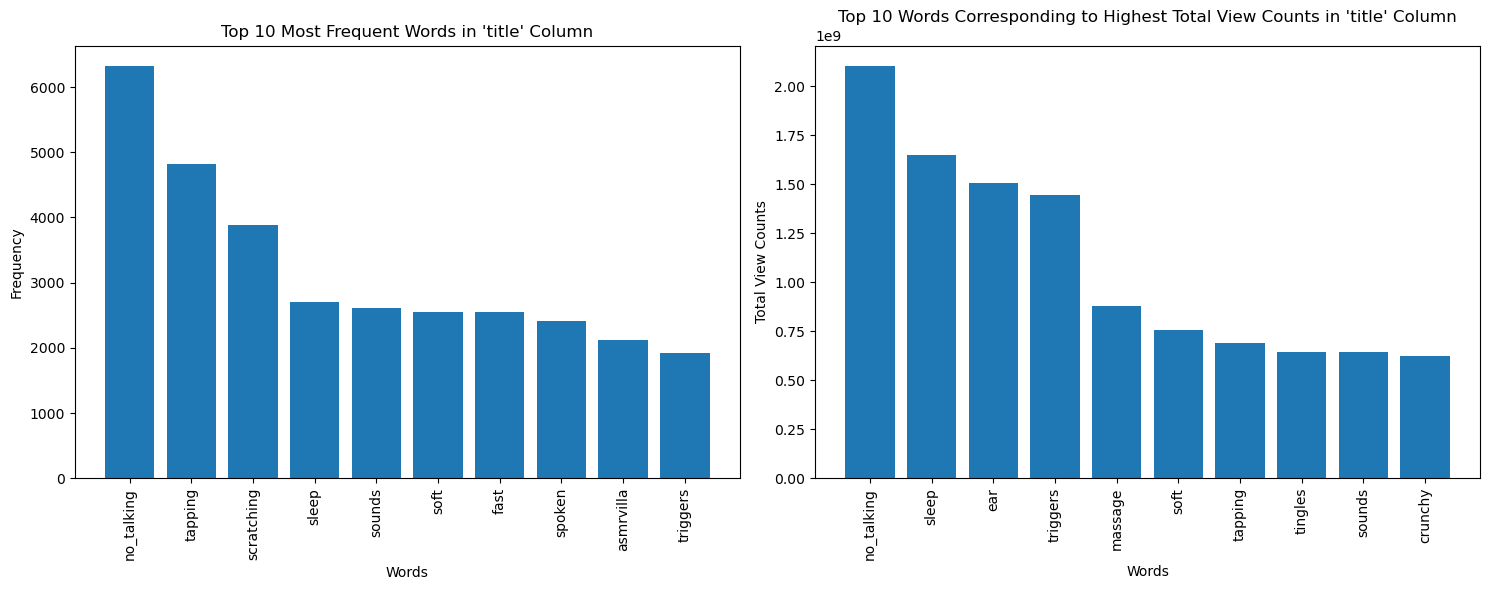

In [45]:
title_top_10_by_views = plot_top_10_words('title', df)

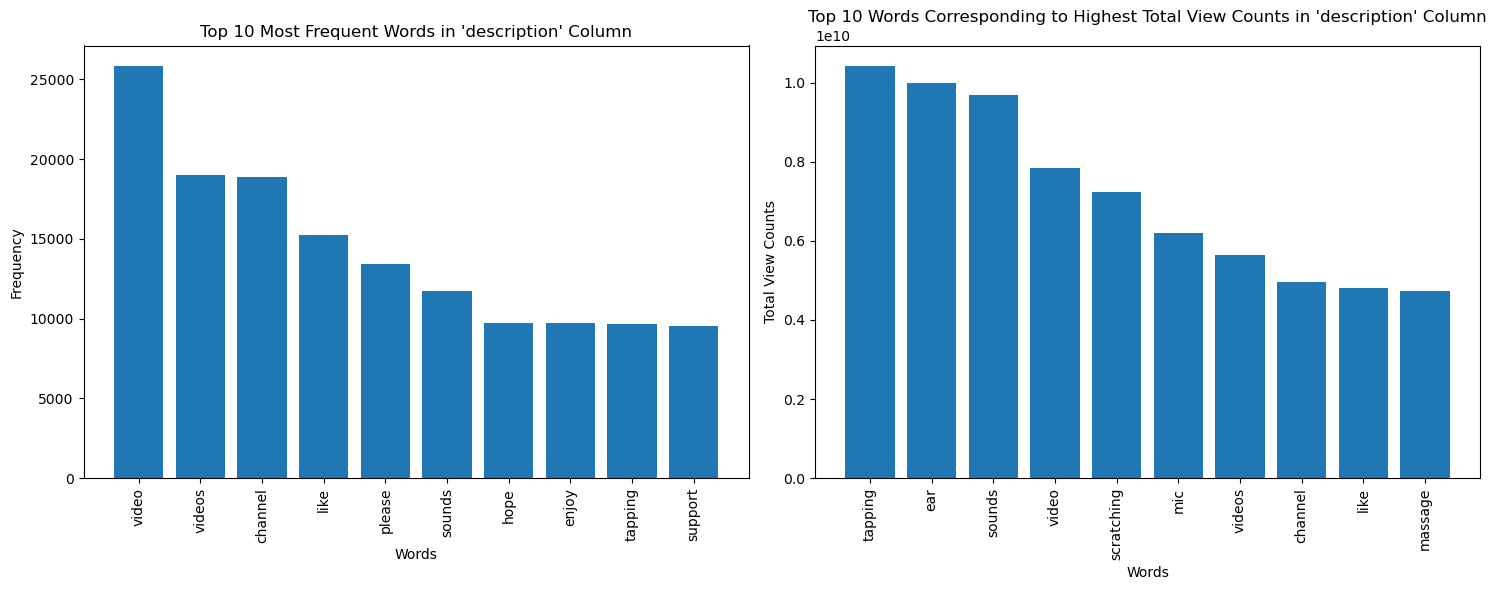

In [46]:
description_top_10_by_views = plot_top_10_words('description', df)

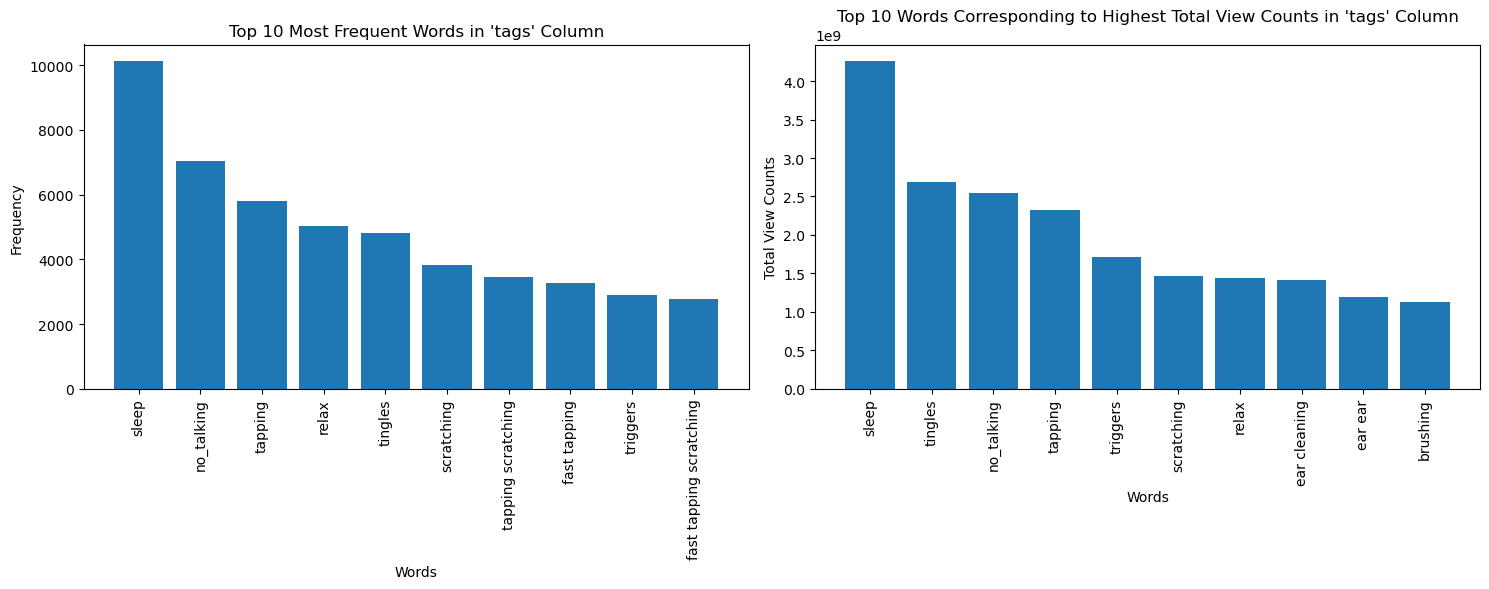

In [47]:
tags_top_10_by_views = plot_top_10_words('tags', df)

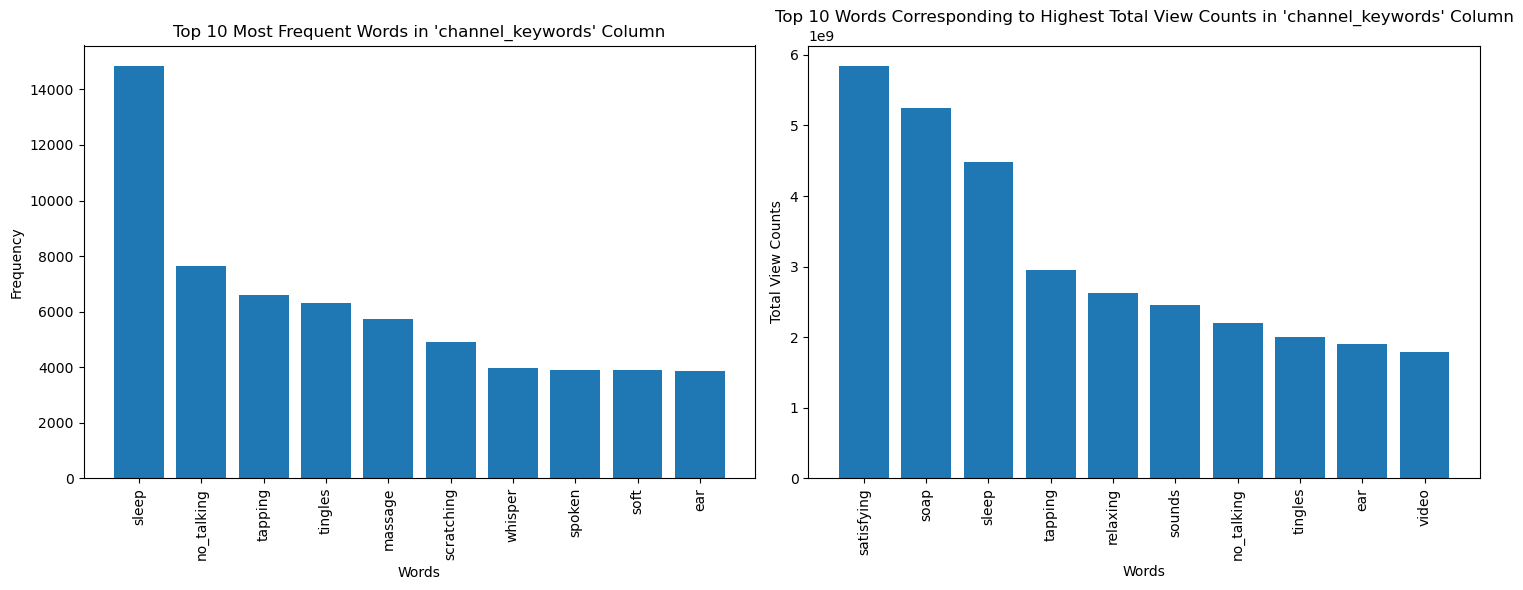

In [48]:
keywords_top_10_by_views = plot_top_10_words('channel_keywords', df)

In [49]:
def one_hot_encode_column(column_title, words_phrases, dataframe):
    for word_or_phrase in words_phrases:
        search_phrase = word_or_phrase.replace('_', ' ')
        new_column_name = f"{column_title}_{word_or_phrase.replace(' ', '_')}"
        
        if new_column_name not in dataframe.columns:
            dataframe[new_column_name] = 0
        
        dataframe.loc[
            dataframe[column_title].apply(lambda x: isinstance(x, str) and search_phrase.lower() in x.lower()),
            new_column_name
        ] = 1
        
    return dataframe


In [50]:
df = one_hot_encode_column('title', title_top_10_by_views, df)
df = one_hot_encode_column('description', title_top_10_by_views, df)
df = one_hot_encode_column('tags', title_top_10_by_views, df)
df = one_hot_encode_column('channel_keywords', keywords_top_10_by_views, df)

In [51]:
df.head(5)

,video_id,published_at,channel_id,title,description,channel_title,tags,duration,definition,caption,...,channel_keywords_satisfying,channel_keywords_soap,channel_keywords_sleep,channel_keywords_tapping,channel_keywords_relaxing,channel_keywords_sounds,channel_keywords_no_talking,channel_keywords_tingles,channel_keywords_ear,channel_keywords_video
0,jmoYpP4QPN8,2023-08-09 15:00:12-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR Mic Scratching Brain Scratching with 9 M...,In this ASMR no talking video i am scratching ...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr mic scratchi...",2403,hd,False,...,0,0,1,1,0,0,1,0,0,1
1,V-49I6-L0UE,2023-08-07 15:00:15-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR 20 Up Close Triggers in 20 Minutes Scra...,In this ASMR no talking video I am combining d...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr scratching',...",1201,hd,False,...,0,0,1,1,0,0,1,0,0,1
2,mrFKMa5e6-I,2023-08-04 15:00:28-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR ONLY 0001 CAN REACH S TIER WITHOUT SLEEPI...,In this ASMR no talking video I am comparing d...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr scratching',...",682,hd,False,...,0,0,1,1,0,0,1,0,0,1
3,rqc_pS88_TM,2023-08-02 15:00:15-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR 20 Triggers in 20 Minutes Scratching T...,In this ASMR no talking video I am combining d...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr scratching',...",1239,hd,False,...,0,0,1,1,0,0,1,0,0,1
4,swyWOoa4xvw,2023-07-31 15:00:22-05:00,UC6pDS2qoRTcf0FFGARnS_tg,ASMR Mic Scratching Brain Scratching with 9 M...,In this ASMR no talking video i am scratching ...,Alexa ASMR,"['asmr', 'asmr no talking', 'asmr mic scratchi...",2403,hd,False,...,0,0,1,1,0,0,1,0,0,1


## Export Cleaned Data for EDA

In [52]:
list_of_columns = df.columns.tolist()
print(list_of_columns)

['video_id', 'published_at', 'channel_id', 'title', 'description', 'channel_title', 'tags', 'duration', 'definition', 'caption', 'view_count', 'like_count', 'comment_count', 'channel_description', 'channel_keywords', 'channel_subscriber_count', 'channel_video_count', 'channel_published_at', 'duplicate_count', 'duplicate_view_count', 'duplicate_changes', 'category', 'channel_age', 'video_age', 'hour_of_day_published', 'day_of_week_published', 'title_non_english', 'description_non_english', 'title_emoji', 'description_emoji', 'title_word_count', 'description_word_count', 'tag_count', 'title_no_talking', 'title_sleep', 'title_ear', 'title_triggers', 'title_massage', 'title_soft', 'title_tapping', 'title_tingles', 'title_sounds', 'title_crunchy', 'description_no_talking', 'description_sleep', 'description_ear', 'description_triggers', 'description_massage', 'description_soft', 'description_tapping', 'description_tingles', 'description_sounds', 'description_crunchy', 'tags_no_talking', 'tag

In [53]:
import ast
import json

text_columns = ['title', 'description', 'channel_title', 'channel_description', 'channel_keywords']

def clean_string(s):
    s = s.strip()
    s = s.replace('\n', ' ')
    s = re.sub('\s+', ' ', s)
    return s

def clean_string_list(string_list):
    if isinstance(string_list, str):
        string_list = ast.literal_eval(string_list)
    
    cleaned_list = [clean_string(s) for s in string_list]
    return json.dumps(cleaned_list)

list_columns = ['tags']

for col in list_columns:
    df[col] = df[col].apply(clean_string_list)
for col in text_columns:
    df[col] = df[col].apply(clean_string)


In [54]:
tag_test = df.copy()
tag_test=tag_test['tags']
tag_test.head(4)


0    ["asmr", "asmr no talking", "asmr mic scratchi...
1    ["asmr", "asmr no talking", "asmr scratching",...
2    ["asmr", "asmr no talking", "asmr scratching",...
3    ["asmr", "asmr no talking", "asmr scratching",...
Name: tags, dtype: object

In [58]:
import ast
import csv

channel_columns = ['channel_id', 'channel_title', 'channel_description', 'channel_keywords',
                   'channel_subscriber_count', 'channel_video_count', 'channel_published_at',
                   'channel_age']

summarize_columns = ['duration', 'view_count', 'like_count', 'comment_count', 'duplicate_count',
                     'duplicate_view_count', 'duplicate_changes', 'title_non_english', 'description_non_english',
                     'title_emoji', 'description_emoji', 'title_word_count', 'description_word_count',
                     'tag_count', 'title_no_talking', 'title_sleep', 'title_ear',
                     'title_triggers', 'title_massage', 'title_soft', 'title_tapping', 'title_tingles',
                     'title_sounds', 'title_crunchy', 'description_no_talking', 'description_sleep',
                     'description_ear', 'description_triggers', 'description_massage', 'description_soft',
                     'description_tapping', 'description_tingles', 'description_sounds', 'description_crunchy',
                     'tags_no_talking', 'tags_sleep', 'tags_ear', 'tags_triggers', 'tags_massage', 'tags_soft',
                     'tags_tapping', 'tags_tingles', 'tags_sounds', 'tags_crunchy']


df_sorted = df.sort_values(by='published_at')
df_channel_info = df_sorted[channel_columns].drop_duplicates(subset=['channel_id'], keep='last')

grouped_df = df.groupby('channel_id')[summarize_columns].agg({
    col: 'sum' for col in summarize_columns
})

final_df = df_channel_info.merge(grouped_df, on='channel_id', how='left')

def video_counts(duration_list):
    full_videos_count = sum(1 for duration in duration_list if duration > 60)
    shorts_count = sum(1 for duration in duration_list if duration <= 60)
    return full_videos_count, shorts_count

video_counts_df = df.groupby('channel_id')['duration'].apply(video_counts).reset_index()
video_counts_df[['full_videos_count', 'shorts_count']] = pd.DataFrame(video_counts_df['duration'].tolist(), index=video_counts_df.index)
video_counts_df.drop(columns=['duration'], inplace=True)

final_df = final_df.merge(video_counts_df, on='channel_id', how='left')
final_df.shape[0]
final_df.to_csv('channel_summary.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)


In [59]:
get_rows_and_duplicates(df)
df.to_csv('all_videos.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

The df has 24082 rows.
There are 1302 duplicate titles.


In [60]:
df_long_duration = df[df['duration'] > 60]
df_short_duration = df[df['duration'] <= 60]

df_long_duration.to_csv('full_videos.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)
df_short_duration.to_csv('shorts_videos.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)